  Copyright ©2021. Stephen Rigden.
  This program is free software: you can redistribute it and/or modify
  it under the terms of the GNU General Public License as published by
  the Free Software Foundation, either version 3 of the License, or
  (at your option) any later version.
  This program is distributed in the hope that it will be useful,
  but WITHOUT ANY WARRANTY; without even the implied warranty of
  MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
  GNU General Public License for more details.
  You should have received a copy of the GNU General Public License
  along with this program.  If not, see <http://www.gnu.org/licenses/>.

# Plot Blood Pressure

Change History
9/28/2021 Started
10/15/2021 Reviewed and tidied up for production use.
10/23/2021 Modified to use pandas resampling toolset instead of iso_date

In [1]:
import pandas
from pathlib import Path
from matplotlib import pyplot
import seaborn
seaborn.set_style('darkgrid')  # one of {darkgrid, whitegrid, dark, white, ticks}

In [2]:
heart_preprocessed = Path.cwd().parent / 'data' / 'processed'/ 'heart_preprocessed.pickle'
blood_pressure_df_pickle = Path.cwd().parent / 'data' / 'processed' / 'blood_pressure_df.pickle'
blood_pressure_pdf = Path.cwd().parent / 'reports' / 'blood_pressure.pdf'
blood_pressure_jpg = Path.cwd().parent / 'reports' / 'blood_pressure.jpg'

### Get the raw data and analyse its structure

In [3]:
ds = pandas.read_pickle(heart_preprocessed)
ds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 189184 entries, 5 to 189188
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   value   189184 non-null  float64       
 1   type    189184 non-null  object        
 2   date    189184 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 5.8+ MB


In [4]:
ds['type'].value_counts()

HKQuantityTypeIdentifierHeartRate                 188620
HKQuantityTypeIdentifierBloodPressureSystolic        282
HKQuantityTypeIdentifierBloodPressureDiastolic       282
Name: type, dtype: int64

In [5]:
ds.head()

,value,type,date
5,67.0,HKQuantityTypeIdentifierHeartRate,2020-03-30 20:11:49
6,67.0,HKQuantityTypeIdentifierHeartRate,2020-03-30 20:16:17
7,61.0,HKQuantityTypeIdentifierHeartRate,2020-03-30 20:21:09
8,64.0,HKQuantityTypeIdentifierHeartRate,2020-03-30 20:21:13
9,63.0,HKQuantityTypeIdentifierHeartRate,2020-03-30 20:21:18


In [6]:
ds.tail()

,value,type,date
189184,73.0,HKQuantityTypeIdentifierBloodPressureDiastolic,2021-10-28 23:03:00
189185,70.0,HKQuantityTypeIdentifierBloodPressureDiastolic,2021-10-28 23:39:00
189186,78.0,HKQuantityTypeIdentifierBloodPressureDiastolic,2021-10-29 20:13:00
189187,70.0,HKQuantityTypeIdentifierBloodPressureDiastolic,2021-10-29 21:13:00
189188,68.0,HKQuantityTypeIdentifierBloodPressureDiastolic,2021-10-29 23:06:00


### Create a dataset of blood pressure records

In [7]:
bp_diastolic = ds['type'] == 'HKQuantityTypeIdentifierBloodPressureDiastolic'
dds = ds.loc[bp_diastolic, ['date', 'value']]
dds = dds.rename(columns={'value': 'diastolic'})
dds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 282 entries, 188907 to 189188
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       282 non-null    datetime64[ns]
 1   diastolic  282 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 6.6 KB


In [8]:
dds.head()

,date,diastolic
188907,2021-08-06 20:53:00,79.0
188908,2021-08-06 20:58:00,85.0
188909,2021-08-06 23:13:00,77.0
188910,2021-08-07 01:14:00,73.0
188911,2021-08-07 22:21:00,71.0


In [9]:
bp_systolic = ds['type'] == 'HKQuantityTypeIdentifierBloodPressureSystolic'
sds = ds.loc[bp_systolic, ['date', 'value']]
sds = sds.rename(columns={'value': 'systolic'})
sds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 282 entries, 188625 to 188906
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      282 non-null    datetime64[ns]
 1   systolic  282 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 6.6 KB


In [10]:
sds.head()

,date,systolic
188625,2021-08-06 20:53:00,153.0
188626,2021-08-06 20:58:00,136.0
188627,2021-08-06 23:13:00,135.0
188628,2021-08-07 01:14:00,121.0
188629,2021-08-07 22:21:00,132.0


In [11]:
bpds = sds.merge(dds, left_on=['date'], right_on=['date'])
bpds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 282 entries, 0 to 281
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       282 non-null    datetime64[ns]
 1   systolic   282 non-null    float64       
 2   diastolic  282 non-null    float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 8.8 KB


In [12]:
bpds.head()

,date,systolic,diastolic
0,2021-08-06 20:53:00,153.0,79.0
1,2021-08-06 20:58:00,136.0,85.0
2,2021-08-06 23:13:00,135.0,77.0
3,2021-08-07 01:14:00,121.0,73.0
4,2021-08-07 22:21:00,132.0,71.0


In [13]:
bpds['pulse_pressure'] = bpds['systolic'] - bpds['diastolic']
bpds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 282 entries, 0 to 281
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            282 non-null    datetime64[ns]
 1   systolic        282 non-null    float64       
 2   diastolic       282 non-null    float64       
 3   pulse_pressure  282 non-null    float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 11.0 KB


In [14]:
bpds.head()

,date,systolic,diastolic,pulse_pressure
0,2021-08-06 20:53:00,153.0,79.0,74.0
1,2021-08-06 20:58:00,136.0,85.0,51.0
2,2021-08-06 23:13:00,135.0,77.0,58.0
3,2021-08-07 01:14:00,121.0,73.0,48.0
4,2021-08-07 22:21:00,132.0,71.0,61.0


In [15]:
ds.to_pickle(blood_pressure_df_pickle)

## Group by varying periods using [resample](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.core.groupby.DataFrameGroupBy.resample.html?highlight=resample#pandas.core.groupby.DataFrameGroupBy.resample)
#### Create a DatetimeIndex

In [16]:
bpds.head()

,date,systolic,diastolic,pulse_pressure
0,2021-08-06 20:53:00,153.0,79.0,74.0
1,2021-08-06 20:58:00,136.0,85.0,51.0
2,2021-08-06 23:13:00,135.0,77.0,58.0
3,2021-08-07 01:14:00,121.0,73.0,48.0
4,2021-08-07 22:21:00,132.0,71.0,61.0


In [17]:
bpdsi = bpds.set_index('date')
bpdsi.head()

,systolic,diastolic,pulse_pressure
date,,,
2021-08-06 20:53:00,153.0,79.0,74.0
2021-08-06 20:58:00,136.0,85.0,51.0
2021-08-06 23:13:00,135.0,77.0,58.0
2021-08-07 01:14:00,121.0,73.0,48.0
2021-08-07 22:21:00,132.0,71.0,61.0


In [18]:
bpdsi_day = bpdsi.resample('D').mean()
bpdsi_day.head()

,systolic,diastolic,pulse_pressure
date,,,
2021-08-06,141.333333,80.333333,61.00
2021-08-07,125.400000,73.000000,52.40
2021-08-08,128.875000,75.625000,53.25
2021-08-09,126.500000,78.000000,48.50
2021-08-10,122.000000,75.000000,47.00


<AxesSubplot:xlabel='date'>

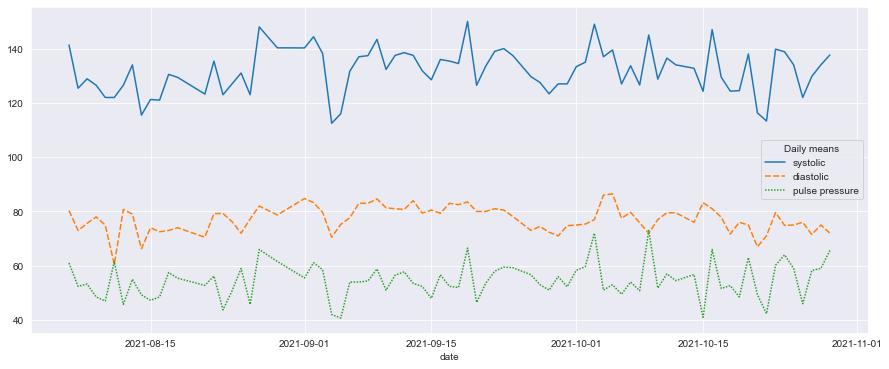

In [19]:
fig, axes_ = pyplot.subplots(figsize=(15, 6))
plot = seaborn.lineplot(data=bpdsi_day, palette='tab10', linewidth=1.5, ax=axes_)
plot.legend(labels=['systolic', 'diastolic', 'pulse pressure'], title='Daily means')
plot

In [20]:
fig.savefig(blood_pressure_jpg)
fig.savefig(blood_pressure_pdf)